# Visual Question Answering

## Installing Libraries

In [1]:
# %pip install ftfy regex tqdm --user
# %pip install pandas --user
# %pip install wordcloud --user
# %pip install sklearn --user
# %pip install scikit-learn --user
# %pip install Levenshtein --user

In [2]:
%pip install git+https://github.com/openai/CLIP.git --user

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-q96mx4l8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-q96mx4l8
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=77cef20886f45f29d9ef00874f58f8af0b0e653a5d49a0647739dc7ff0931536
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4itv5wg/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

## Global Variables

In [4]:
INPUT_PATH = '/kaggle/input/vizwiz'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/kaggle/working/'
ANSWER_SPACE = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device: ", DEVICE)

Device:  cuda


## Processing Data

In [5]:
def read_dataframe(path):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def save_dataframe(dataframe, path, type = 'train'):

    path+= 'dataframes' if path =='' else '/dataframes'
    if not os.path.exists(path):
        os.makedirs(path)

    if type == 'train':
        dataframe.to_csv(path + '/train.csv', index=False)
    elif type == 'val':
        dataframe.to_csv(path + '/val.csv', index=False)
    else:
        dataframe.to_csv(path + '/test.csv', index=False)

def split_train_test(dataframe, test_size = 0.05):
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test


def plot_histogram(dataframe, column):
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()


def plot_boxplot(dataframe, column):
    plt.boxplot(dataframe[column])
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):

    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):
    
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')
    

def get_number_of_distinct_answers(dataframe):
    # Create a set to count the number of unique answers
    unique_answers_set = set()

    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

## Creating Dataframes & Splitting

In [6]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df)
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


## Exploratory Data Analysis

### Training Dataframe

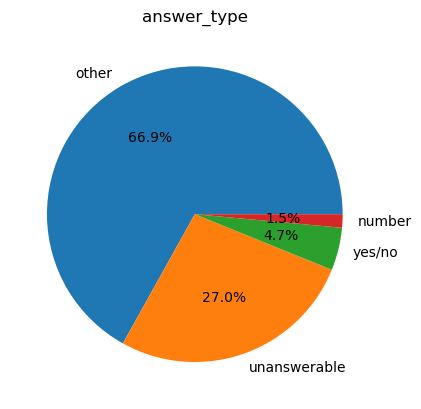

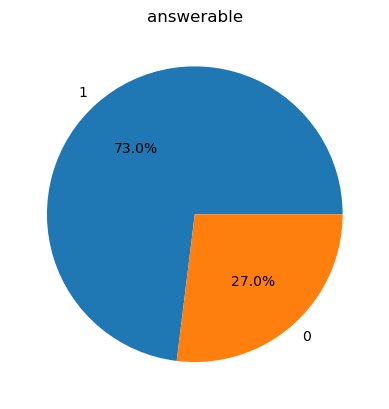

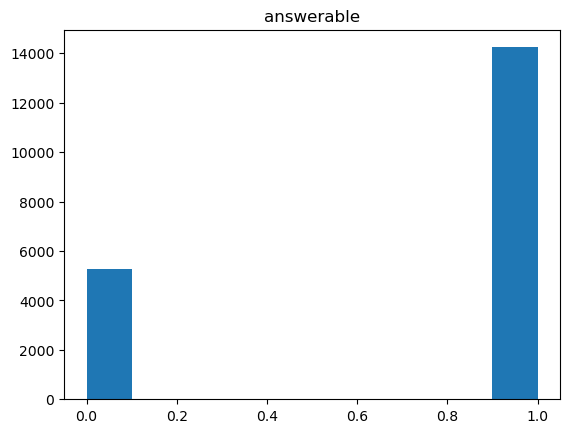

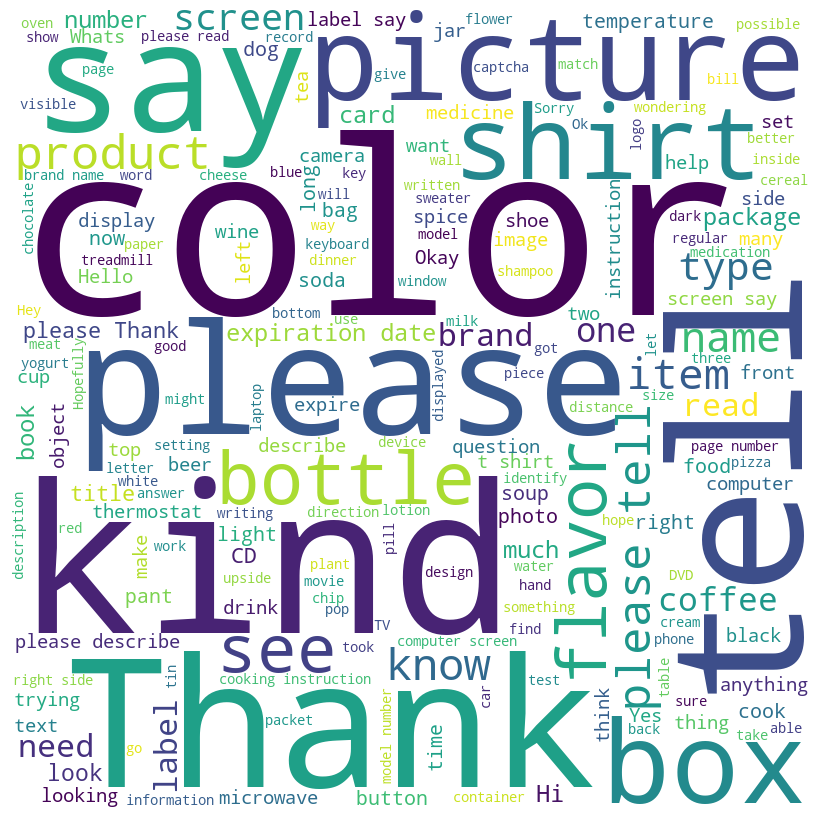

Number of distinct answers:  39515
Number of samples in train:  19496


In [7]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### Validation Dataframe

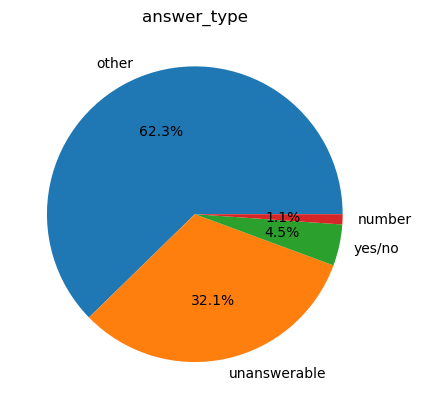

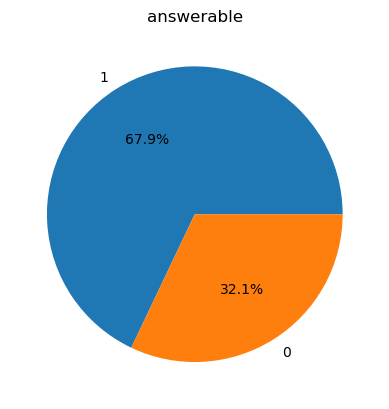

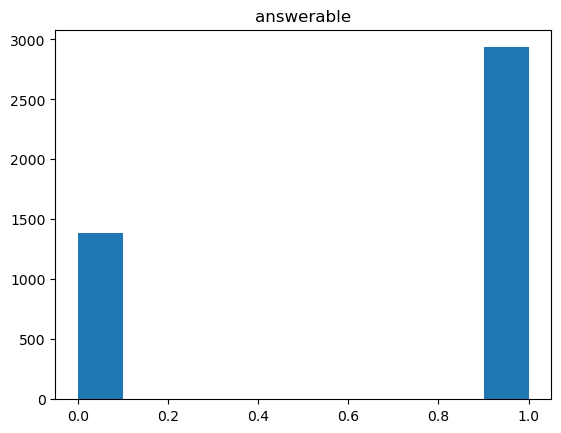

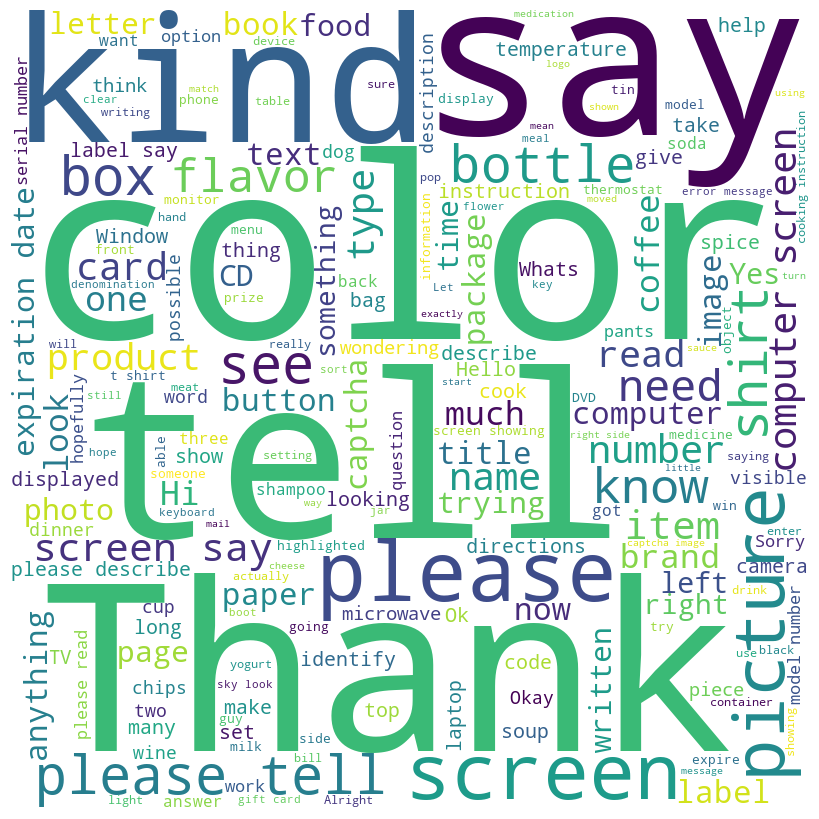

Number of distinct answers:  10905
Number of samples in validation set:  4319


In [8]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### Testing Dataframe

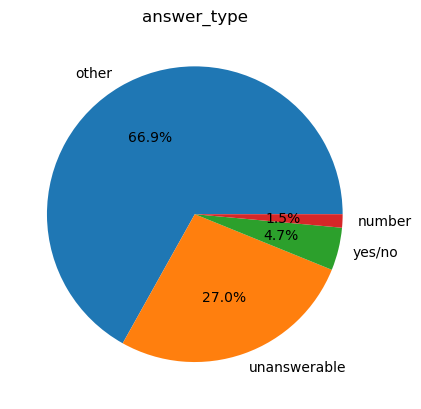

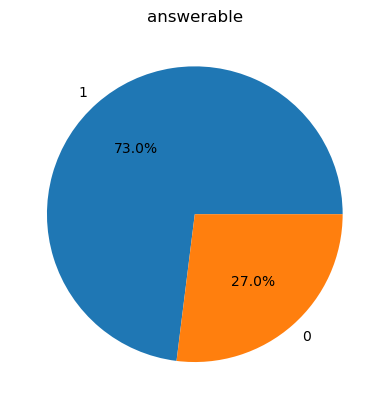

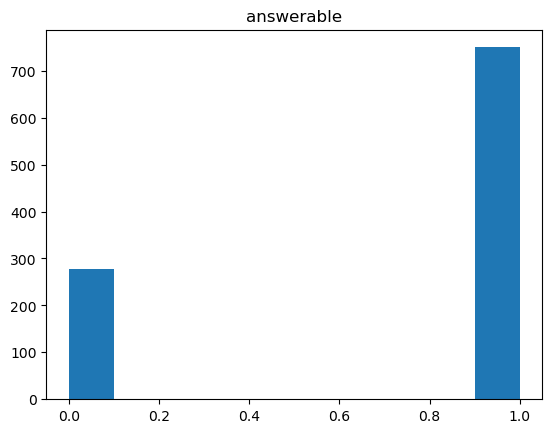

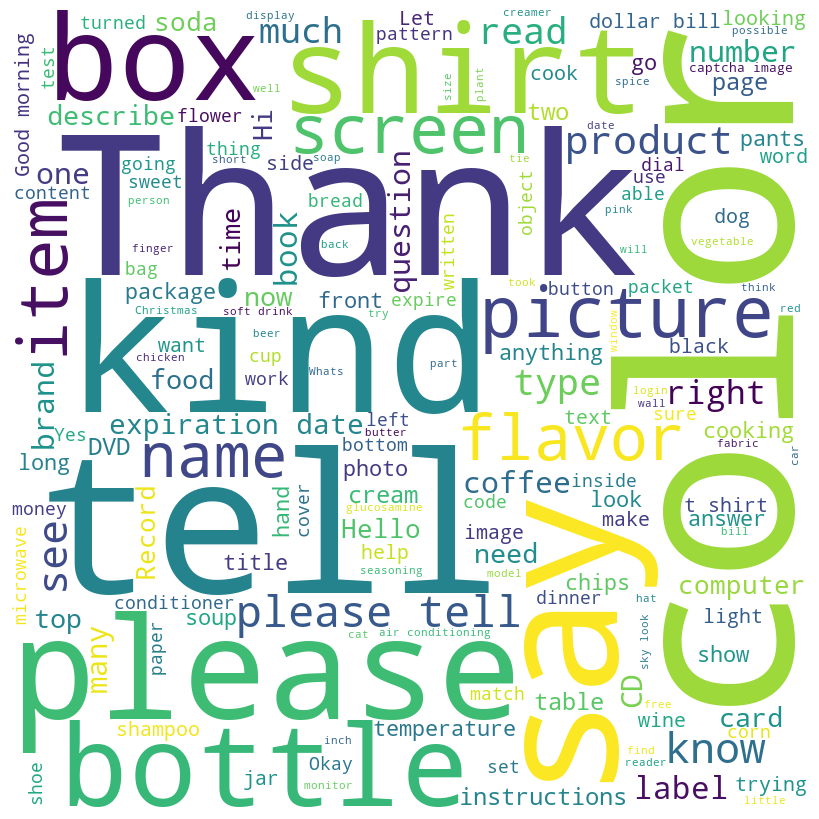

Number of distinct answers:  3007
Number of samples in test:  1027


In [9]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

## Creating Model

In [10]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "RN50x64", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []
        self.device = device
        self.model_name = model_name
        self.clip_model, self.preprocess = clip.load(model_name, device = device)
        
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # now let's add our own layers
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes) 
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, image, question):
        
        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)
        
        features = self.linear_layer1(features)

        answer_type = self.answer_type_layer(features)
        final_answer_type = self.softmax(answer_type)

        answer_mask = self.answer_mask_layer(answer_type)
        answer_mask = self.sigmoid(answer_mask)

        output = self.linear_layer2(features)

        output = output * answer_mask

        output = self.softmax(output)

        return output, final_answer_type
    
    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy = self.validation_step(validation_dataloader, criterion, self.device)

            test_accuracy = self.test_step(test_dataloader)
            print("Epoch: {} | Training Loss: {} | Validation Loss: {}".format(epoch, training_loss, validation_loss))
            print("Training Accuracy: {} | Validation Accuracy: {} | Test Accuracy: {}\n".format(training_accuracy, validation_accuracy, test_accuracy))
            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
            
        return self.training_losses, self.validation_losses


    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss = 0.0
        training_accuracy = 0.0
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, counter_for_question = batch
            image, question, answer, answer_type= image.to(device), question.to(device), answer.to(device), answer_type.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted = self.forward(image, question)
            loss = criterion(output, answer) + criterion(answer_type, answer_type_predicted)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            number_of_correct_answers = counter_for_question[torch.argmax(output, dim = 1)]
            training_accuracy += min(1, number_of_correct_answers/3)
        training_loss /= len(dataloader)
        training_accuracy /= len(dataloader)
        return training_loss, training_accuracy
            
    
    def validation_step(self, dataloader, criterion, device):
        validation_loss = 0.0
        validation_accuracy = 0.0
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, counter_for_question = batch
                image, question, answer, answer_type = image.to(device), question.to(device), answer.to(device), answer_type.to(device)
                output, answer_type_predicted = self.forward(image, question)
                loss = criterion(output, output) + criterion(answer_type, answer_type_predicted)
                validation_loss += loss.item()
                number_of_correct_answers = counter_for_question[torch.argmax(output, dim = 1)]
                validation_accuracy += min(1, number_of_correct_answers/3)
        validation_loss /= len(dataloader)
        validation_accuracy /= len(dataloader)
        return validation_loss, validation_accuracy
    
    def test_step(self, dataloader):
        self.eval()
        accuracy = 0.0
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, counter_for_question = batch
                image, question, answer, answer_type = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device)
                output, _ = self.forward(image, question)
                predicted_answer = torch.argmax(output, dim = 1)
                number_of_correct_answers = counter_for_question[predicted_answer]
                accuracy += min(1, number_of_correct_answers/3)
        accuracy /= len(dataloader)
        return accuracy

    def save_model(self, path):
        torch.save(self.state_dict(), path)
    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()
        return self
    
    def predict(self, image, question):
        output, answer_type = self.forward(image, question)
        predicted_answer = torch.argmax(output, dim = 1)
        predicted_answer_type = torch.argmax(answer_type, dim = 1)
        return predicted_answer, predicted_answer_type
    
    def plot_history(self):
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        image = Image.open(image_path)
        
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        
        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        
        predicted_answer, predicted_answer_type = self.predict(image_features, text_features)
        print("Predicted Answer:", predicted_answer.item())
        print("Predicted Answer Type:", predicted_answer_type.item())

    def print_CLIP_model(self):

        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)

## Creating Dataset Class

In [15]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, image_path = "", answer_type_onehotencoder = None, answer_onehotencoder = None, model_name = "RN50x64"):

        super(VizWizDataset, self).__init__()

        self.answer_counter = Counter() # A total counter for all answers before filtering, used in Tie Breaking
        self.images_features = [] # A list of image features
        self.questions_features = [] # A list of question features
        # let's create an array of counter to count answers for each question
        self.answer_counter_per_question = []

        self.dataframe = dataframe
        self.image_path = image_path
        self.clip_model, self.preprocess = clip.load(model_name, device = torch.device("cpu"))

        self.build_answer_counter()
        self.build_answer_vocab()
        print("Number of distinct answers: ", len(self.get_answer_vocab()))


        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])
            
        self.answer_type_onehotencoder = answer_type_onehotencoder

        
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])
            
        self.answer_onehotencoder = answer_onehotencoder
        
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()
        
        # After making one hot encoding, we need to populate answer_counter_per_question array for each question
        self.build_answer_counter_per_question()
        self.dataframe = self.copied_dataframe
        self.process_images()
        self.process_questions()
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        return self.images[index], self.questions[index], answer, answer_type, self.answer_counter_per_question[index]

    def build_answer_counter_per_question(self):
        for index, row in self.dataframe.iterrows():
            answer_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                answer_index = self.answer_onehotencoder.transform([[answer]]).toarray().argmax()
                answer_counter.update([answer_index])
            self.answer_counter_per_question.append(answer_counter)

    def process_images(self):
        self.images = []
        for _, row in self.dataframe.iterrows():
            full_path = self.image_path + "/" + row['image']
            image = Image.open(full_path)
            image = self.preprocess(image).unsqueeze(0)
            image_features = self.clip_model.encode_image(image)
            self.images.append(image_features)

    def process_questions(self):
        self.questions = []
        for _, row in self.dataframe.iterrows():
            question = row['question']
            question =  clip.tokenize(question)
            text_features = self.clip_model.encode_text(question).float()
            self.questions.append(text_features)

            
    def build_answer_vocab(self):
        # Building answer vocab follow this policy:
        # for each 10 answers for a question, we choose the most frequent answer
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.
        
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        # add extra column named 'answer'
        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])
            
            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance which we have built before
                    current_min = np.inf
                    current_answer = None
                    # now let's build levenshtein distance between the answers in top_elements and each others and select the minimum
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])
    
    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()
    
    def reverse_onehotencode_answer(self, answer_one_hot_encoded, answer_type_one_hot_encoded):
        answer = self.answer_onehotencoder.inverse_transform(answer_one_hot_encoded)
        answer_type = self.answer_type_onehotencoder.inverse_transform(answer_type_one_hot_encoded)
        return answer, answer_type

## Playing Around

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
print("Device: ", DEVICE)

training_dataset = VizWizDataset(train_df, TRAIN_PATH, None, None, MODEL_NAME)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder
validation_dataset = VizWizDataset(validation_df, VALIDATION_PATH, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME)
test_dataset = VizWizDataset(test_df, TRAIN_PATH, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME)

BATCH_SIZE = 1
NUM_WORKERS = 4

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Device:  cuda
Number of distinct answers:  5410


In [ ]:
NUM_EPOCHS = 30
LR = 1e-3
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = None #OUTPUT_PATH
SAVE_EVERY = 1

model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
#model.print_CLIP_model()

loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_history()

## Test your own image !

In [ ]:
# QUESTION = "What is the color of the shirt?"
# IMAGE_PATH = ""
# model.test_model(image_path = IMAGE_PATH, question = QUESTION)